In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import glob
import random as r
import skimage.io as io
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, UpSampling2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        
        if label == 1:
            img[img != 0 ] = 1 # tam tümör
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # ödemsiz tümör
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # genişleyen tümör
            img[img == 4 ] = 1
         
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!

def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32)

In [ ]:
flair = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*flair.nii.gz')
t2 = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*t2.nii.gz')
seg = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 1)

In [9]:
x_train = np.concatenate((flair, t2), axis=1) #axis: kacinci index birlestirilecek. Axis 1 olacak cunku zaten tek kanal 1,240,240

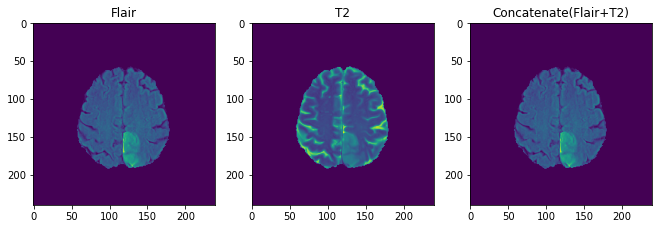

In [5]:
x= 50
fig = plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('Flair')
plt.imshow(flair[x][0])

plt.subplot(142)
plt.title('T2')
plt.imshow(t2[x][0])

plt.subplot(143)
plt.title('Concatenate(Flair+T2)')
plt.imshow(x_train[x][0])

In [10]:
K.set_image_data_format('channels_first') # (240,240,1) => (1,240,240) yani katman sayisi ilk

def dice_coef(y_true, y_pred): #[piksel farki] https://i.stack.imgur.com/OsH4y.png
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model():
    inputs = Input((2, 240 , 240)) #sum of the shapes of the flair and t2 
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model    

In [11]:
model = unet_model()

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='D://modelweight//new.h5', monitor='val_accuracy', restore_best_weights=True)]

history = model.fit(x_train, seg, validation_split=0.2, batch_size = 10, epochs=10, shuffle=True, verbose=1, callbacks=[callback], initial_epoch = 6)

Epoch 7/10
2067/2067 [==============================] - 1362s 659ms/step - loss: 0.3269 - dice_coef: 0.6732 - val_loss: 0.4125 - val_dice_coef: 0.5870
Epoch 8/10
 101/2067 [>.............................] - ETA: 19:51 - loss: 0.1225 - dice_coef: 0.8775

In [101]:
model.save_weights('D://modelweight//final.h5')

In [7]:
model.load_weights('D://modelweight//final.h5')

In [21]:
print(x_train.shape)

(8750, 2, 240, 240)


In [29]:
example = np.expand_dims(x_train[200], axis=0)

In [30]:
pred = model.predict(example)

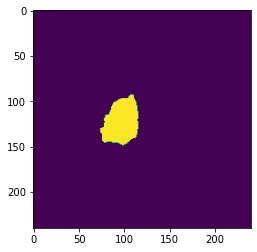

In [31]:
plt.imshow(pred[0][0])

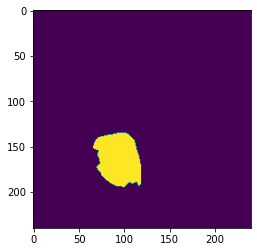

In [12]:
plt.imshow(seg[120][0])

In [1]:
print(flair.shape)

NameError: name 'flair' is not defined

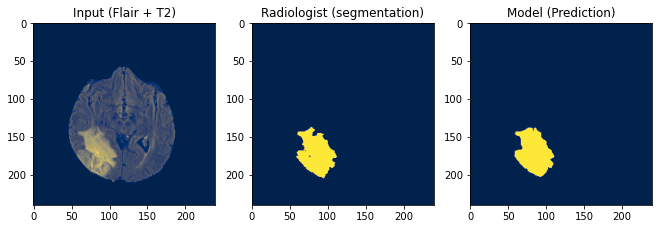

In [14]:
x    = 3500
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 4

example = np.expand_dims(x_train[x],axis=0)
pred = model.predict(example)


fig = plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('Input (Flair + T2)')
plt.imshow(x_train[x][0],cmap = renk[a])

plt.subplot(142)
plt.title('Radiologist (segmentation)')
plt.imshow( seg[x][0],cmap = renk[a])

plt.subplot(143)
plt.title('Model (Prediction)')
plt.imshow( pred[0][0],cmap = renk[a])

In [6]:
t1ce = train_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*t1ce.nii.gz')

In [7]:
seg_odemsiz = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 3)

In [8]:
seg_necrosis = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 2)
seg_enhancing = seg_array('C:\\Users\\Fatih\\Desktop\\dataset\\', '**\\*seg.nii.gz', 4)

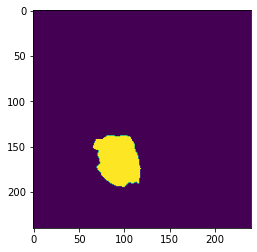

In [9]:
tmp = seg_odemsiz[120,0,:,:]
plt.imshow(tmp)

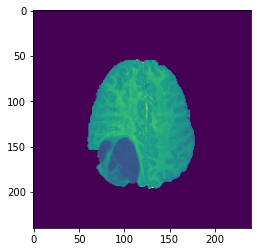

In [10]:
x = t1ce[120,0,:,:]
plt.imshow(x)

In [11]:
def tumor_clipping(mr,seg):
    mr = mr[0]
    list = []
    tmp = seg[0,:,:]
    
    tmp[tmp>0.2] = 1
    tmp[tmp!=1] = 0
    index_xy = np.where(tmp==1)
    
    if index_xy[0] != []:
        center_y = (max(index_xy[0]) + (min(index_xy[0]))) / 2
        center_x = (max(index_xy[1]) + (min(index_xy[1]))) / 2
        img_x = np.zeros((64,64), np.float32)
        img_x[:,:] = mr[int(center_y - 64/2):int(center_y + 64/2),int(center_x - 64/2):int(center_x + 64/2)]
        list.append(img_x)
    return np.array(list)

In [12]:
t1ce_def = tumor_clipping(t1ce[120],seg_odemsiz[120])
odemsiz_def = tumor_clipping(seg_odemsiz[120],seg_odemsiz[120])

<ipython-input-11-91cdab79729b>:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if index_xy[0] != []:


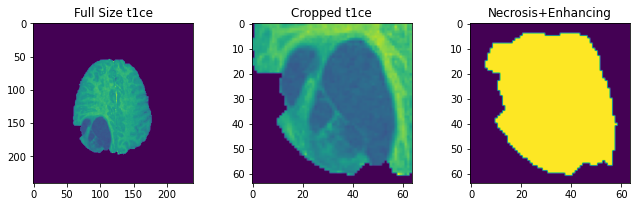

In [15]:
fig = plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('Full Size t1ce')
plt.imshow(t1ce[120,0,:,:])

plt.subplot(3,4,2)
plt.title('Cropped t1ce')
plt.imshow(t1ce_def[0])

plt.subplot(3,4,3)
plt.title('Necrosis+Enhancing')
plt.imshow(odemsiz_def[0])